In [1]:
import numpy as np
import pandas as pd
import datetime as dt

In [2]:
from fbprophet import Prophet
from fbprophet.plot import plot_plotly
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [4]:
data = pd.read_csv("london_merged.csv",parse_dates=[0])

In [5]:
data.head()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


<AxesSubplot:>

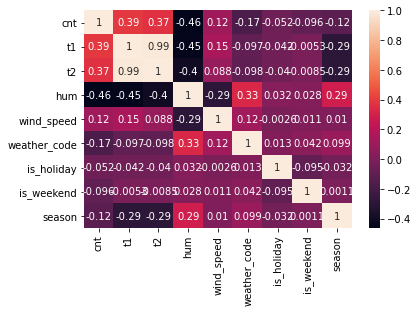

In [6]:
sns.heatmap(data.corr(),annot=True)

In [7]:
#drop t2 since it is highly correlated with t1
data.drop(["t2"],axis=1,inplace=True)

In [8]:
data.columns = ["ds","bike_count","temp","humidity","wind_speed","weather","is_holiday","is_weekend","season"]

In [14]:
#more information about the data, save it if further needed
season = {0: "spring", 1: "summer", 2:"fall", 3:"winter"}
is_holiday = {0: "not holiday", 1: "holiday"}
is_week = {0: "not weekend", 1: "weekend"}
weather_code = {1: "clear", 2: "scattered clouds", 3: "broken clouds",
                4: "cloudy", 7: "rain/ light rain",
                10: "rain with thunderstorm", 26: "snowfall", 94: "freezing fog"}

In [9]:
#there is no missing value in the dataframe
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17414 entries, 0 to 17413
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   ds          17414 non-null  datetime64[ns]
 1   bike_count  17414 non-null  int64         
 2   temp        17414 non-null  float64       
 3   humidity    17414 non-null  float64       
 4   wind_speed  17414 non-null  float64       
 5   weather     17414 non-null  float64       
 6   is_holiday  17414 non-null  float64       
 7   is_weekend  17414 non-null  float64       
 8   season      17414 non-null  float64       
dtypes: datetime64[ns](1), float64(7), int64(1)
memory usage: 1.2 MB


In [12]:
data.drop_duplicates(inplace=True)
data.duplicated().sum().sum()

0

In [13]:
#Quick look at the data, the earliest timestamp in the data is 04 Jan 2015 and the latest one is 03 Jan 2017
data.ds.describe(datetime_is_numeric=True)

count                            17414
mean     2016-01-03 22:31:00.571953664
min                2015-01-04 00:00:00
25%                2015-07-04 20:15:00
50%                2016-01-03 15:30:00
75%                2016-07-04 15:45:00
max                2017-01-03 23:00:00
Name: ds, dtype: object

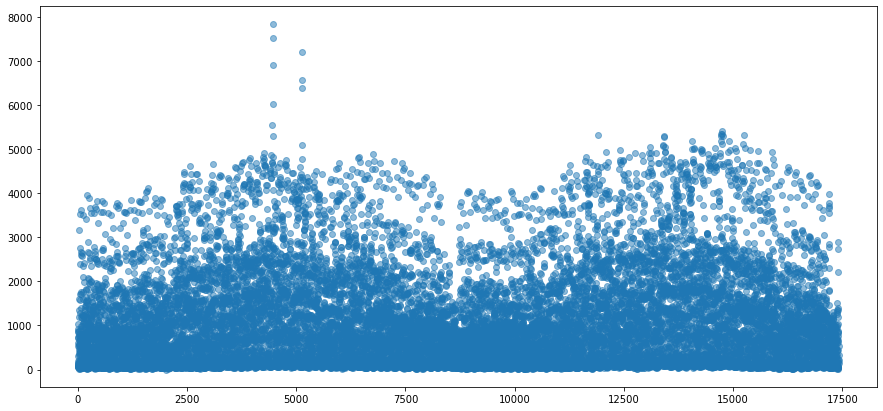

In [9]:
f, ax = plt.subplots()
f.set_figheight(7)
f.set_figwidth(15)
ax.scatter(data.index, data.bike_count,alpha=0.5)

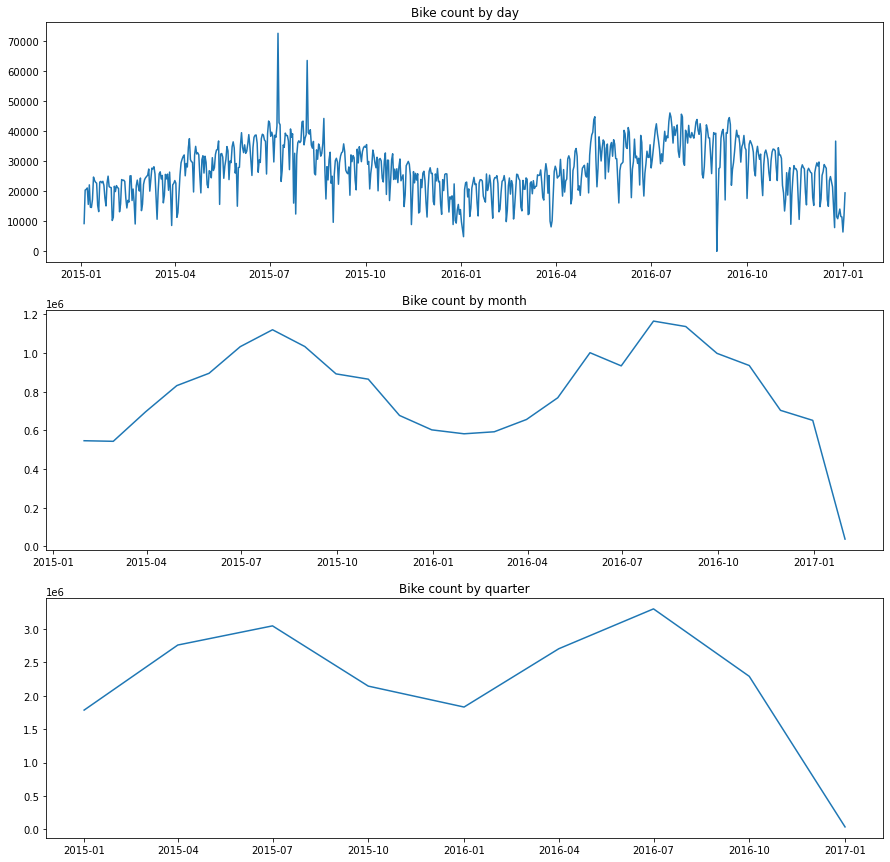

In [26]:
f, ax = plt.subplots(3)
f.set_figheight(15)
f.set_figwidth(15)
ax[0].set_title("Bike count by day")
ax[1].set_title("Bike count by month")
ax[2].set_title("Bike count by quarter")
ax[0].plot(data.set_index(["ds"]).resample("d").bike_count.sum());
ax[1].plot(data.set_index(["ds"]).resample("m").bike_count.sum());
ax[2].plot(data.set_index(["ds"]).resample("qs").bike_count.sum());

<div style='background-color:navy; color:white; padding:20px'>
      There is a quite clear pattern in the number of bike shares. Bike was shared most in the summer (especially in Jul and Aug), and reaching its bottom peak in Jan.
</div>

In [38]:
# fig, ax = plt.subplots(2,2, figsize=(12,10))

# sns.boxplot(ax=ax[0,0],x="weather", y="bike_count", data=data)
# sns.boxplot(ax=ax[0,1],x="season", y="bike_count", data=data)
# sns.boxplot(ax=ax[1,0],x="is_holiday", y="bike_count", data=data)
# sns.boxplot(ax=ax[1,1],x="is_weekend", y="bike_count", data=data)
# fig.show()

# PROPHET

In [39]:
#split data for training and testing
split_point = max(data.ds) - pd.to_timedelta(int((len(data.ds)/24)*0.3),unit="d")
split_point_index = data[data.ds==split_point].index.tolist()[0]

X = data[["ds","temp","humidity","wind_speed","weather","is_holiday","is_weekend","season"]]
y = data["bike_count"]

data_train=data[:split_point_index]
X_train= X[:split_point_index]
X_test = X[split_point_index:]
y_train= y[:split_point_index]
y_test = y[split_point_index:]

## Based on Date only

In [40]:
df_train_1 = pd.DataFrame({"ds":X_train.ds,"y": y_train})
df_test_1 = pd.DataFrame({"ds": X_test["ds"], "y": y_test})

In [41]:
prophet_1 = Prophet(yearly_seasonality=True)

In [42]:
def plot_check(model, df_train, df_test):

    model.fit(df_train)
    pred_df = model.predict(df_test.iloc[:,:-1])
    
    fig, ax = plt.subplots()
    fig.set_figheight(8)
    fig.set_figwidth(15)
    ax.scatter(df_test.ds, df_test.y, color='r')
    fig = model.plot(pred_df,ax=ax)
    plt.show()
    
    MSE = mean_squared_error(y_true=y_test,y_pred= pred_df.yhat)
    MAE = mean_absolute_error(y_true=y_test,y_pred=pred_df.yhat)
    train_score=r2_score(y_true=y_train, y_pred=model.predict(df_train.iloc[:,:-1]).yhat)
    test_score = r2_score(y_true= y_test,y_pred=pred_df.yhat)
    
    error_df = pd.DataFrame({"MSE":[MSE],
                            "MAE":[MAE],
                            "train_score": [train_score],
                            "test_score":[test_score]})
    return error_df
    

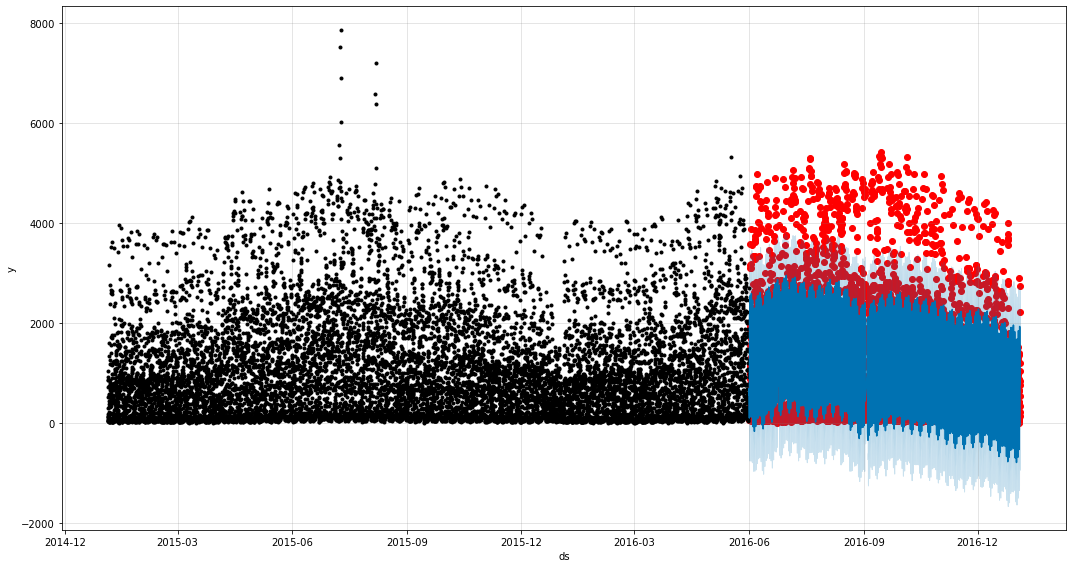

,MSE,MAE,train_score,test_score
0,571636.670166,530.549406,0.584033,0.582436


In [43]:
plot_check(prophet_1, df_train_1,df_test_1)

<div style='background-color:navy; color:white; padding:20px'>
      It can be seen clearly from the graph that "Date" only does not help to predict the future well. Thus, more features need to be considered.
</div>

## Prophet with holidays

In [44]:
holiday = X_train[X_train["is_holiday"]==1][["is_holiday","ds"]]
holiday["is_holiday"] = "holiday"
holiday.columns = ["holiday","ds"]

In [45]:
prophet_2 = Prophet(holidays=holiday, yearly_seasonality=True)

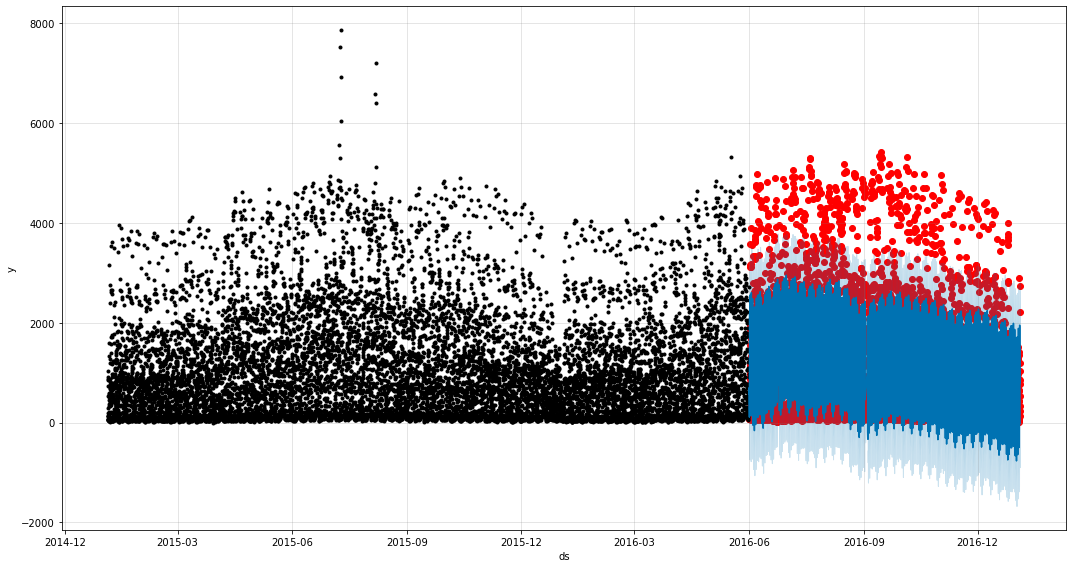

,MSE,MAE,train_score,test_score
0,570737.767238,530.293284,0.584968,0.583093


In [46]:
plot_check(prophet_2, df_train_1,df_test_1)

Prophet plots the observed values of our time series (the black dots), the forecasted values (blue line) and the uncertainty intervals of our forecasts (the blue shaded regions).

<div style='background-color:navy; color:white; padding:20px'>
      Considering "holiday" did not help the model perform better significantly. Thus, more features will be considered.
</div>

## Prophet with temp and humidity

In [47]:
df_train_3 = pd.DataFrame({"ds":X_train.ds,
                         "temp":X_train.temp,
                         "humidity": X_train.humidity,
                          "y":y_train})

df_test_3 = pd.DataFrame({"ds":X_test.ds,
                         "temp":X_test.temp,
                         "humidity": X_test.humidity,
                         "y":y_test})

In [48]:
prophet_3 = Prophet(holidays=holiday, yearly_seasonality=True)
prophet_3.add_regressor("temp")
prophet_3.add_regressor("humidity")

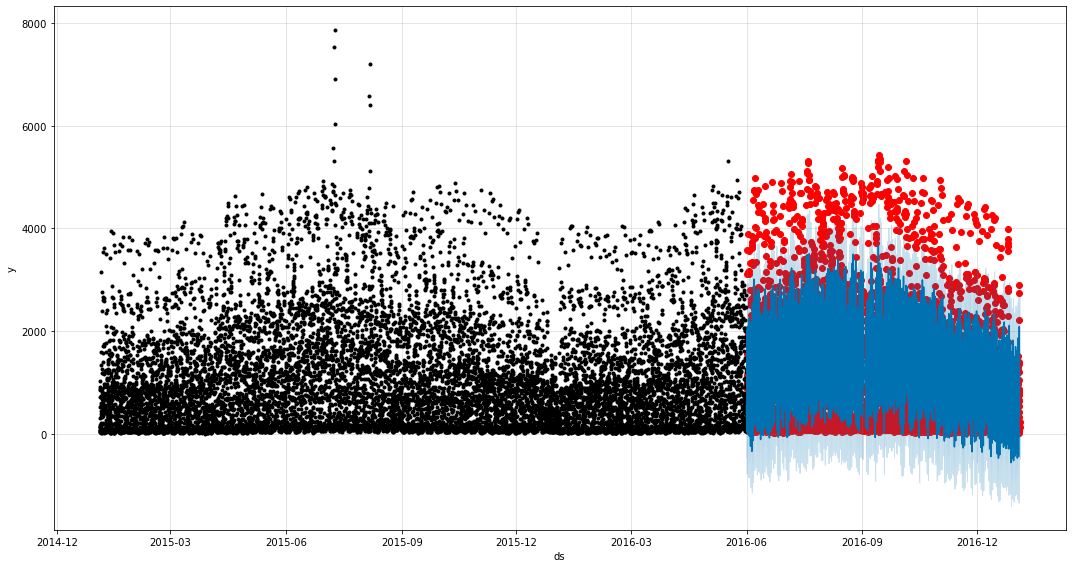

,MSE,MAE,train_score,test_score
0,537673.535186,554.360467,0.620307,0.607245


In [49]:
plot_check(prophet_3, df_train_3, df_test_3)

<div style='background-color:navy; color:white; padding:20px'>
      Taking temp and humidity into account, the model performs better but it seems a bit overfit. Yet, I wont fix overfit for now but later once getting a better score by considering more features.
</div>

## Prophet with temp, humidity, wind_speed, weather and season 

In [50]:
df_train_4 = pd.DataFrame({"ds":X_train.ds, "temp":X_train.temp, "humidity": X_train.humidity,
                           "wind_speed": X_train.wind_speed,"weather": X_train.weather,"is_weekend": X_train.is_weekend,
                           "season": X_train.season, "y":y_train})

df_test_4 = pd.DataFrame({"ds":X_test.ds, "temp":X_test.temp, "humidity": X_test.humidity,
                           "wind_speed": X_test.wind_speed,"weather": X_test.weather, "is_weekend": X_test.is_weekend,
                           "season": X_test.season, "y":y_test})

In [51]:
prophet_4 = Prophet(holidays=holiday, yearly_seasonality=True)
prophet_4.add_regressor("temp")
prophet_4.add_regressor("humidity")
prophet_4.add_regressor("wind_speed")
prophet_4.add_regressor("weather")
prophet_4.add_regressor("is_weekend")
prophet_4.add_regressor("season")

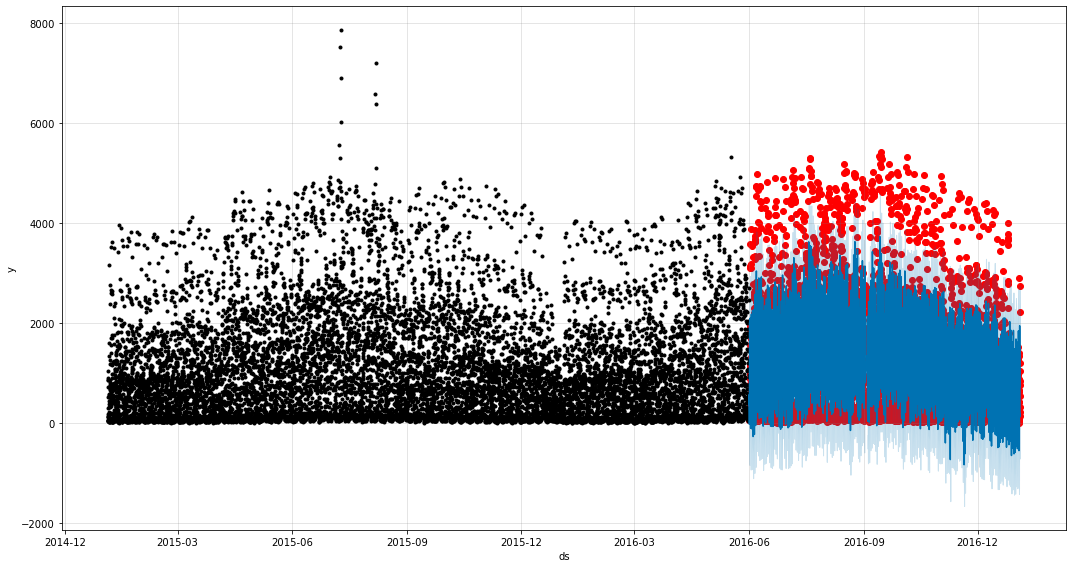

,MSE,MAE,train_score,test_score
0,518523.112308,535.052703,0.627933,0.621234


In [52]:
plot_check(prophet_4, df_train_4, df_test_4)

<div style='background-color:navy; color:white; padding:20px'>
      The lastest model which include all features perform best. However, it only predicts approximately 62% correctly. More considerations to improve the model should be done.
</div>

In [53]:
def outlier_removal(data=data):
    Q1 = data["bike_count"].quantile(0.25)
    Q3 = data["bike_count"].quantile(0.75)
    iqr = Q3 - Q1
    min_= Q1 - 1.5*iqr
    max_= Q3 + 1.5*iqr
    return data.loc[(data["bike_count"] >= min_) & (data["bike_count"] <= max_)]

In [67]:
# data_new = outlier_removal()
# f, ax = plt.subplots()
# f.set_figheight(5)
# f.set_figwidth(12)
# ax.scatter(data_new.index, data_new.bike_count,alpha=0.5)

In [34]:
# data_new = data[data.bike_count <= 5700]
# data_new.reset_index(inplace=True)

In [58]:
split_point_new = max(data_new.ds) - pd.to_timedelta(int((len(data_new.ds)/24)*0.3),unit="d")
split_point_new_index = data_new[data_new.ds==split_point_new].index.tolist()[0]

X_new = data_new[["ds","temp","humidity","wind_speed","weather","is_holiday","is_weekend","season"]]
y_new = data_new["bike_count"]

data_train=data[:split_point_new_index]
X_train_new= X_new[:split_point_new_index]
X_test_new = X_new[split_point_new_index:]
y_train_new= y_new[:split_point_new_index]
y_test_new = y_new[split_point_new_index:]

In [59]:
holiday_new = X_train_new[X_train_new["is_holiday"]==1][["is_holiday","ds"]]
holiday_new["is_holiday"] = "holiday"
holiday_new.columns = ["holiday","ds"]

In [60]:
df_train_5 = pd.DataFrame({"ds":X_train_new.ds, "temp":X_train_new.temp, "humidity": X_train_new.humidity,
                           "wind_speed": X_train_new.wind_speed,"weather": X_train_new.weather,
                           "season": X_train_new.season, "y":y_train_new})

df_test_5 = pd.DataFrame({"ds":X_test_new.ds, "temp":X_test_new.temp, "humidity": X_test_new.humidity,
                           "wind_speed": X_test_new.wind_speed,"weather": X_test_new.weather,
                           "season": X_test_new.season, "y":y_test_new})

In [61]:
prophet_5 = Prophet(holidays=holiday_new, yearly_seasonality=True)
prophet_5.add_regressor("temp")
prophet_5.add_regressor("humidity")
prophet_5.add_regressor("wind_speed")
prophet_5.add_regressor("weather")
prophet_5.add_regressor("season")

In [62]:
prophet_5.fit(df_train_5)

In [63]:
pred_5 = prophet_5.predict(df_test_5)

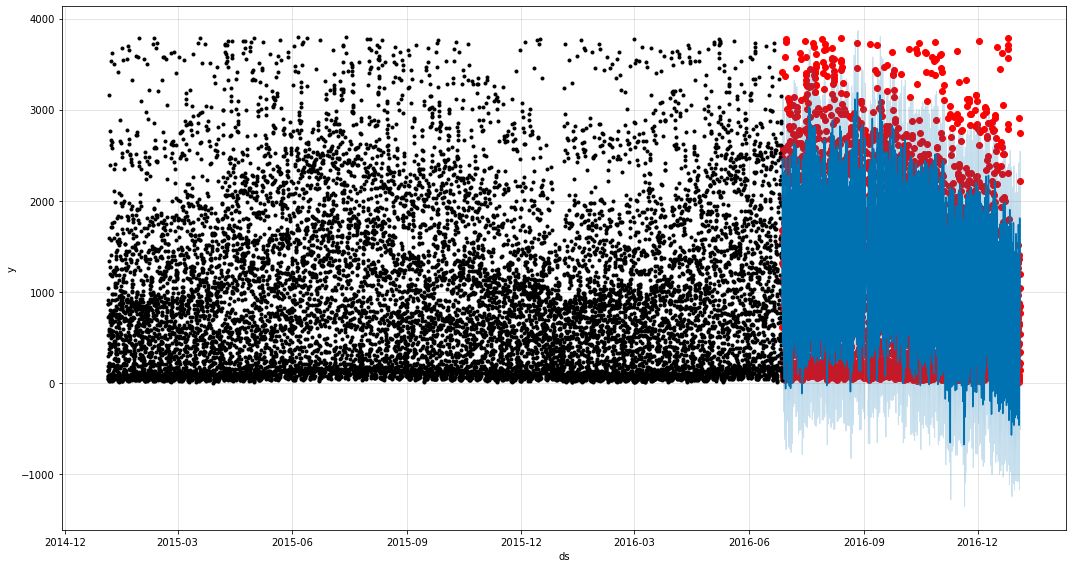

In [78]:
fig, ax = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(15)
ax.scatter(df_test_5.ds, df_test_5.y, color='r')
fig = prophet_5.plot(pred_5,ax=ax)
plt.show()

In [65]:
MSE = mean_squared_error(y_true=y_test_new,y_pred= pred_5.yhat)
MAE = mean_absolute_error(y_true=y_test_new,y_pred=pred_5.yhat)
train_score=r2_score(y_true=y_train_new, y_pred=prophet_5.predict(df_train_5.iloc[:,:-1]).yhat)
test_score = r2_score(y_true= y_test_new,y_pred=pred_5.yhat)
    
error_df = pd.DataFrame({"MSE":[MSE],
                        "MAE":[MAE],
                        "train_score": [train_score],
                        "test_score":[test_score]})


In [66]:
error_df

,MSE,MAE,train_score,test_score
0,284589.820381,411.582837,0.65308,0.654198


<div style='background-color:navy; color:white; padding:20px'>
      After dealing with outliers, the model performed a bit better, from 62% to 65%
</div>

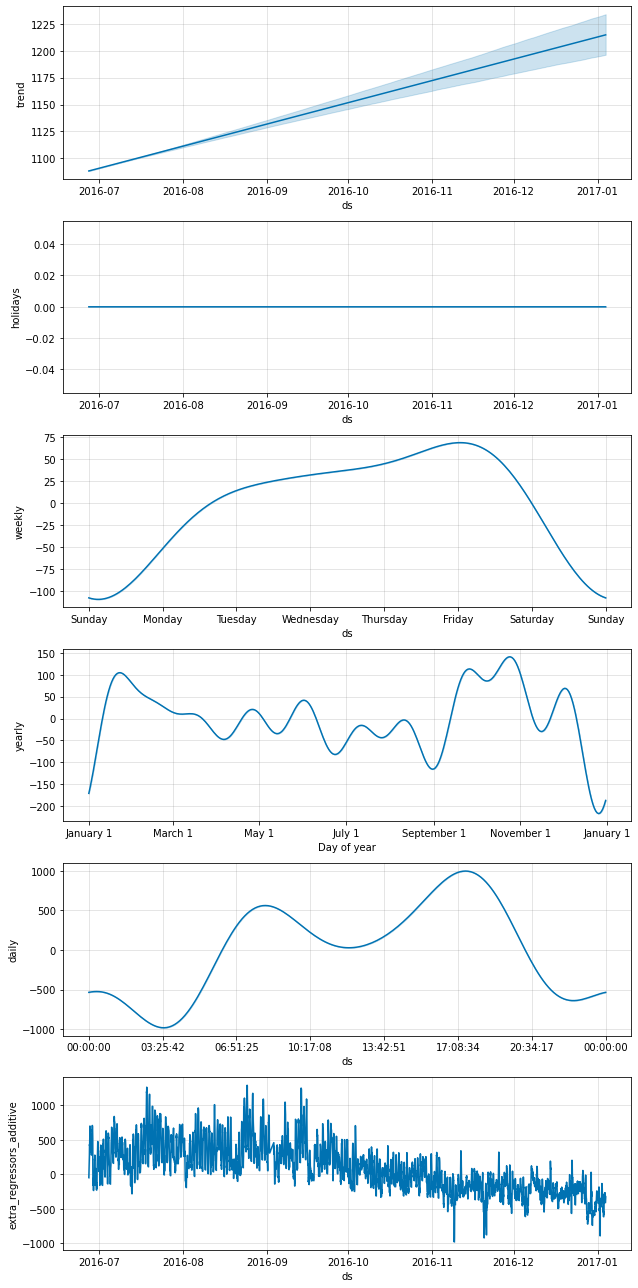

In [71]:
prophet_5.plot_components(pred_5);

<div style='background-color:navy; color:white; padding:20px'>
      The Prophet model using all features after moving all outliers is able to predict 65% correctly the provided data. The model captures no signicant effect of holiday on the number of bike shares. Before removing outliers, some changes in the model was made such changing the growth to logistics with cap = 8000 or adding customed seasonality but the accuracy scores were not significantly improved. 
</div>